# MLP
MLP, K=5, lncRNA.

Droput.

In [13]:
from datetime import datetime
print(datetime.now())

2023-04-06 19:10:15.040117


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=120 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [19]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-06 19:10:16.577858
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 128)               131328    
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 143,809
Trai

## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Correct scores pos:neg',correct_pos,correct_neg)  
        print('Wrong scores pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-06 19:10:16.829289
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.

Training # 1 1
2023-04-06 19:10:26.208516
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-06 19:10:26.221477
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Valid 1:0 458:412 52.64%
FIT
2023-04-06 19:10:26.311161


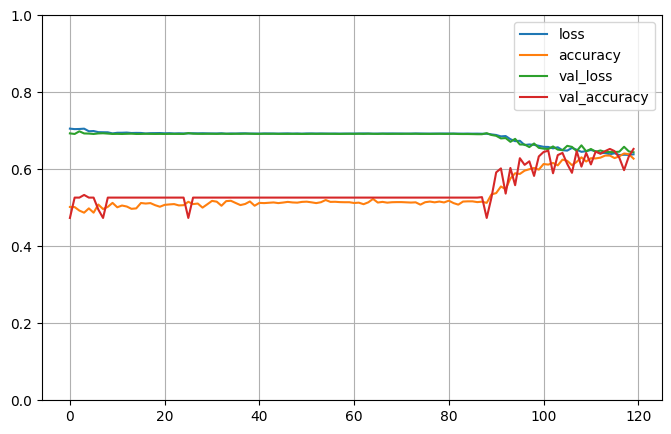


Testing # 1 1
2023-04-06 19:11:43.475225
2023-04-06 19:11:43.475274
PREDICT
2023-04-06 19:11:43.492716
Test 1:0 458:412 52.64%
Predict 1:0 514:356 59.08%
Test sizes (870, 1025) (870,)
Distrib of scores: 0.52780324 mean 0.13626657 std
Range of scores: 0.10772186 to 0.8479613
Score threshold 0.5
Confusion matrix
 [[233 179]
 [123 335]]
Normalized matrix
 [[0.26781609 0.20574713]
 [0.14137931 0.38505747]]
Correct scores pos:neg 124 64
Wrong scores pos:neg 49 19


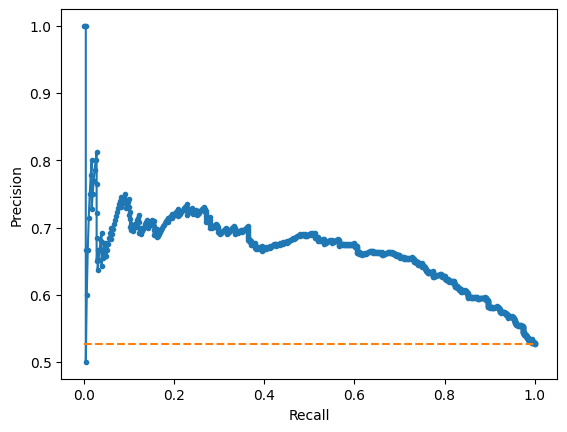

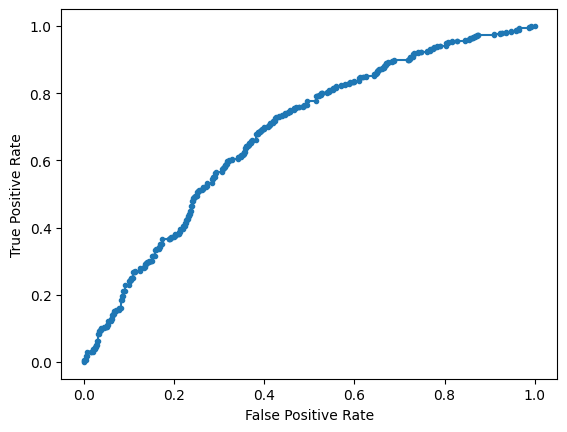

Accuracy: 65.29% Precision: 65.18% Recall: 73.14%
F1: 68.93% MCC: 0.3016
AUPRC: 66.59% AUROC: 68.10%
 accuracy [65.28735632183908]
 precision [65.1750972762646]
 recall [73.14410480349345]
 F1 [68.93004115226337]
 MCC [0.301574572869256]
 AUPRC [66.59077689861779]
 AUROC [68.10001271887056]

Training # 1 2
2023-04-06 19:11:44.105593
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-06 19:11:44.130012
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Valid 1:0 442:442 50.00%
FIT
2023-04-06 19:11:44.240618


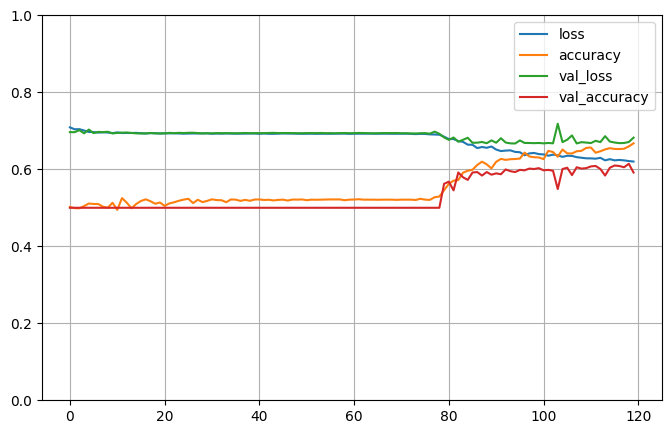


Testing # 1 2
2023-04-06 19:13:03.373723
2023-04-06 19:13:03.373774
PREDICT
2023-04-06 19:13:03.390164
Test 1:0 442:442 50.00%
Predict 1:0 321:563 36.31%
Test sizes (884, 1025) (884,)
Distrib of scores: 0.43161333 mean 0.17857741 std
Range of scores: 0.057463642 to 0.8530893
Score threshold 0.5
Confusion matrix
 [[322 120]
 [241 201]]
Normalized matrix
 [[0.36425339 0.13574661]
 [0.27262443 0.22737557]]
Correct scores pos:neg 73 201
Wrong scores pos:neg 42 113


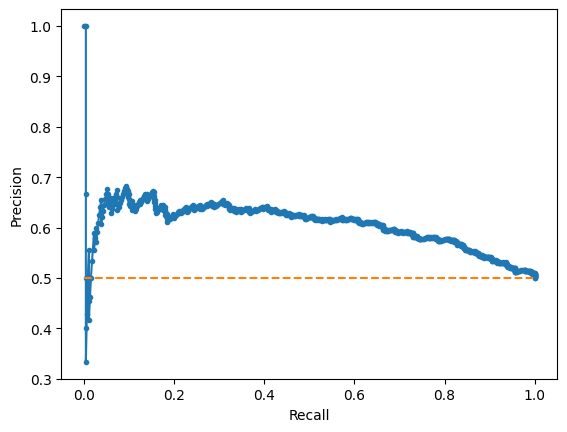

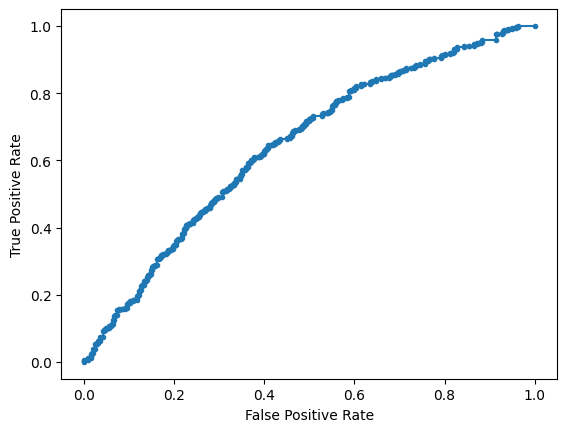

Accuracy: 59.16% Precision: 62.62% Recall: 45.48%
F1: 52.69% MCC: 0.1905
AUPRC: 60.65% AUROC: 64.28%
 accuracy [59.16289592760181]
 precision [62.616822429906534]
 recall [45.47511312217195]
 F1 [52.6867627785059]
 MCC [0.19053655349431792]
 AUPRC [60.64842878016299]
 AUROC [64.27642759157264]

Training # 1 3
2023-04-06 19:13:03.993679
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-06 19:13:04.008078
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Valid 1:0 442:407 52.06%
FIT
2023-04-06 19:13:04.096015


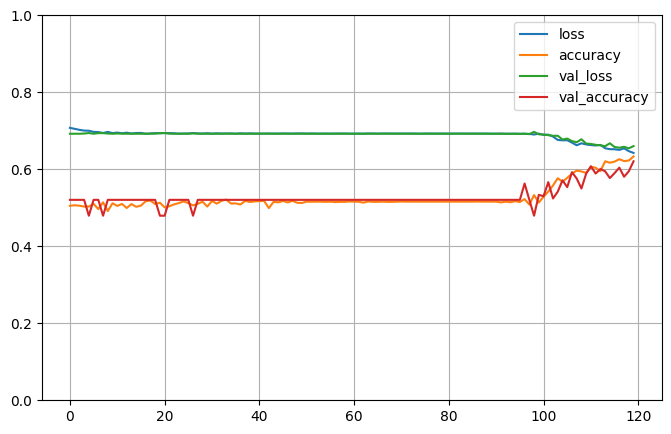


Testing # 1 3
2023-04-06 19:14:27.203272
2023-04-06 19:14:27.203326
PREDICT
2023-04-06 19:14:27.215723
Test 1:0 442:407 52.06%
Predict 1:0 622:227 73.26%
Test sizes (849, 1025) (849,)
Distrib of scores: 0.5789834 mean 0.12585805 std
Range of scores: 0.1811551 to 0.87462497
Score threshold 0.5
Confusion matrix
 [[156 251]
 [ 71 371]]
Normalized matrix
 [[0.18374558 0.29564193]
 [0.0836278  0.43698469]]
Correct scores pos:neg 160 19
Wrong scores pos:neg 69 7


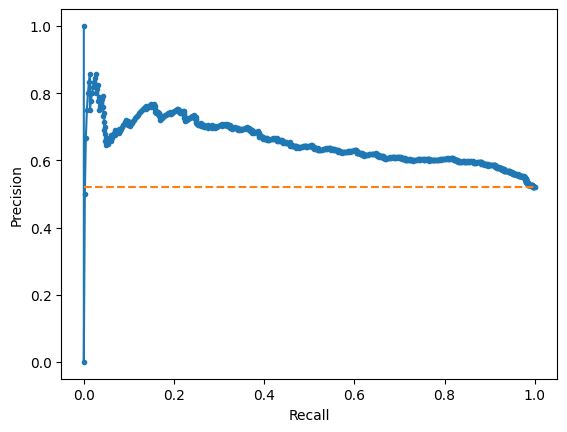

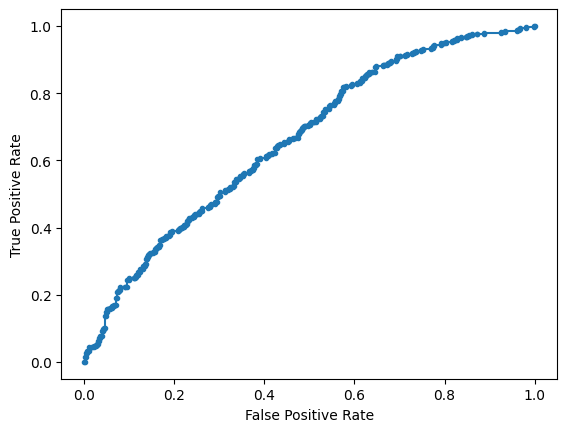

Accuracy: 62.07% Precision: 59.65% Recall: 83.94%
F1: 69.74% MCC: 0.2513
AUPRC: 65.25% AUROC: 66.10%
 accuracy [62.073027090694936]
 precision [59.64630225080386]
 recall [83.93665158371041]
 F1 [69.73684210526316]
 MCC [0.25132765311868394]
 AUPRC [65.24733620587676]
 AUROC [66.10114845408962]

Training # 1 4
2023-04-06 19:14:27.805288
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-06 19:14:27.826715
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Valid 1:0 459:431 51.57%
FIT
2023-04-06 19:14:27.910746


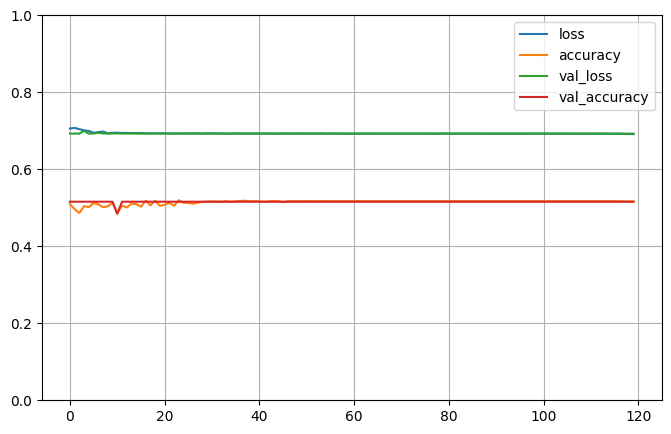


Testing # 1 4
2023-04-06 19:15:51.120311
2023-04-06 19:15:51.120842
PREDICT
2023-04-06 19:15:51.128482
Test 1:0 459:431 51.57%
Predict 1:0 890:0 100.00%
Test sizes (890, 1025) (890,)
Distrib of scores: 0.5219704 mean 0.0029449416 std
Range of scores: 0.5151411 to 0.539413
Score threshold 0.5
Confusion matrix
 [[  0 431]
 [  0 459]]
Normalized matrix
 [[0.         0.48426966]
 [0.         0.51573034]]
Correct scores pos:neg 0 0
Wrong scores pos:neg 0 0


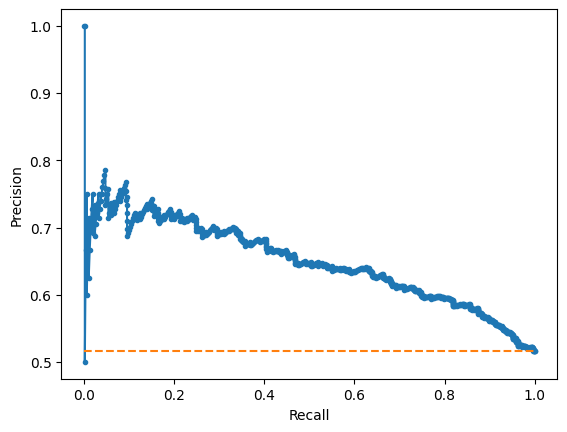

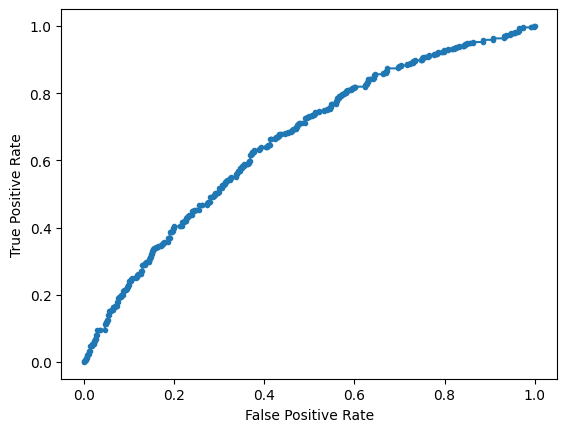

Accuracy: 51.57% Precision: 51.57% Recall: 100.00%
F1: 68.05% MCC: 0.0000
AUPRC: 64.92% AUROC: 65.95%
 accuracy [51.573033707865164]
 precision [51.573033707865164]
 recall [100.0]
 F1 [68.05040770941439]
 MCC [0.0]
 AUPRC [64.91765737989283]
 AUROC [65.95392990916397]

Training # 1 5
2023-04-06 19:15:51.702206
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-06 19:15:51.723746
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Valid 1:0 457:419 52.17%
FIT
2023-04-06 19:15:51.811578


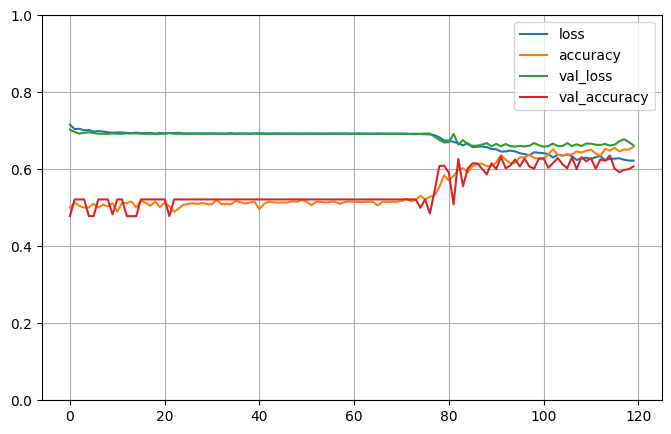


Testing # 1 5
2023-04-06 19:17:15.607565
2023-04-06 19:17:15.607615
PREDICT
2023-04-06 19:17:15.617721
Test 1:0 457:419 52.17%
Predict 1:0 541:335 61.76%
Test sizes (876, 1025) (876,)
Distrib of scores: 0.5421047 mean 0.1622407 std
Range of scores: 0.08198993 to 0.8882735
Score threshold 0.5
Confusion matrix
 [[205 214]
 [130 327]]
Normalized matrix
 [[0.23401826 0.24429224]
 [0.14840183 0.37328767]]
Correct scores pos:neg 162 86
Wrong scores pos:neg 83 39


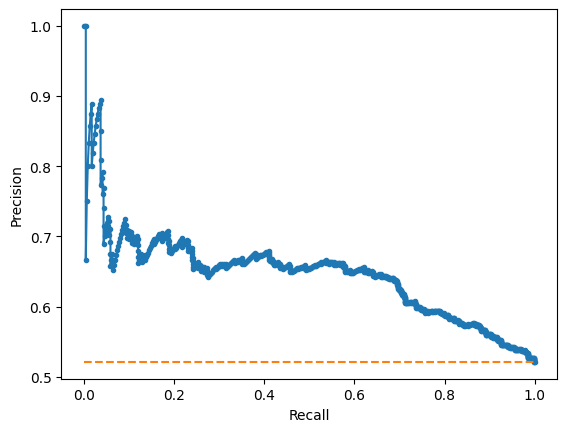

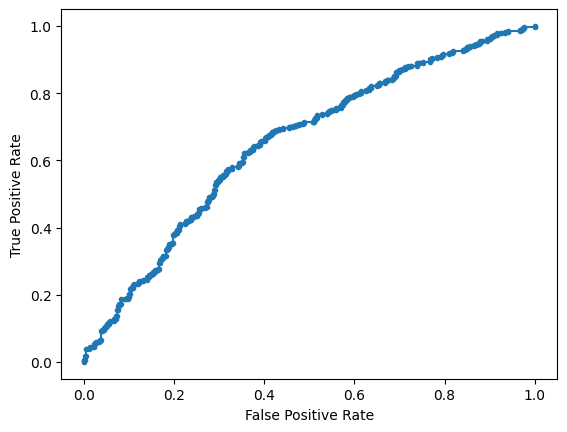

Accuracy: 60.73% Precision: 60.44% Recall: 71.55%
F1: 65.53% MCC: 0.2105
AUPRC: 64.63% AUROC: 65.10%
 accuracy [60.73059360730594]
 precision [60.44362292051756]
 recall [71.55361050328227]
 F1 [65.53106212424849]
 MCC [0.21050677205444152]
 AUPRC [64.63256032073019]
 AUROC [65.10186282855398]

Training # 2 1
2023-04-06 19:17:16.239378
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-06 19:17:16.264179
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Valid 1:0 472:415 53.21%
FIT
2023-04-06 19:17:16.349515


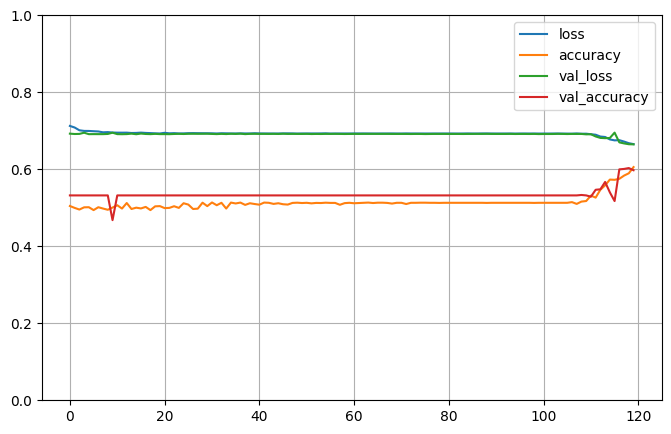


Testing # 2 1
2023-04-06 19:18:32.017070
2023-04-06 19:18:32.017548
PREDICT
2023-04-06 19:18:32.025749
Test 1:0 472:415 53.21%
Predict 1:0 405:482 45.66%
Test sizes (887, 1025) (887,)
Distrib of scores: 0.5010357 mean 0.09152309 std
Range of scores: 0.26014033 to 0.77933496
Score threshold 0.5
Confusion matrix
 [[270 145]
 [212 260]]
Normalized matrix
 [[0.30439684 0.16347238]
 [0.23900789 0.29312289]]
Correct scores pos:neg 44 16
Wrong scores pos:neg 16 8


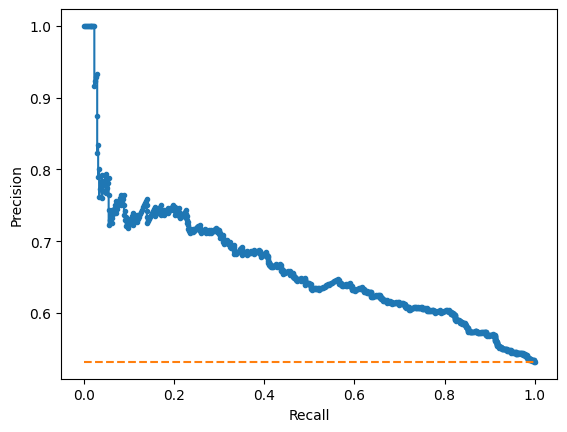

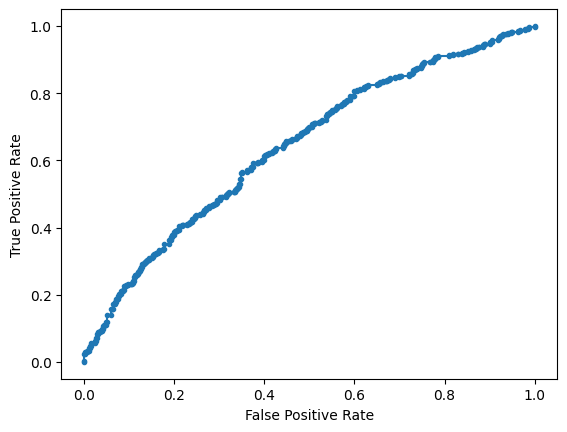

Accuracy: 59.75% Precision: 64.20% Recall: 55.08%
F1: 59.29% MCC: 0.2018
AUPRC: 66.31% AUROC: 64.20%
 accuracy [59.75197294250282]
 precision [64.19753086419753]
 recall [55.08474576271186]
 F1 [59.293044469783354]
 MCC [0.20179527937859681]
 AUPRC [66.30701744076283]
 AUROC [64.20257300387992]

Training # 2 2
2023-04-06 19:18:32.991137
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-06 19:18:33.026658
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Valid 1:0 452:416 52.07%
FIT
2023-04-06 19:18:33.150741


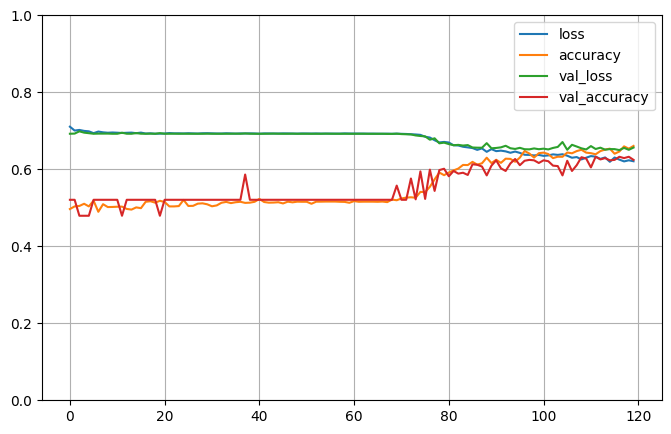


Testing # 2 2
2023-04-06 19:19:49.477693
2023-04-06 19:19:49.477742
PREDICT
2023-04-06 19:19:49.487161
Test 1:0 452:416 52.07%
Predict 1:0 384:484 44.24%
Test sizes (868, 1025) (868,)
Distrib of scores: 0.47356635 mean 0.1730649 std
Range of scores: 0.04996724 to 0.87286687
Score threshold 0.5
Confusion matrix
 [[287 129]
 [197 255]]
Normalized matrix
 [[0.33064516 0.14861751]
 [0.22695853 0.2937788 ]]
Correct scores pos:neg 107 158
Wrong scores pos:neg 47 69


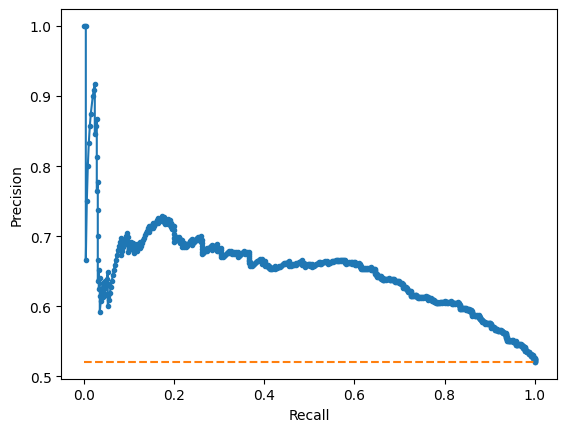

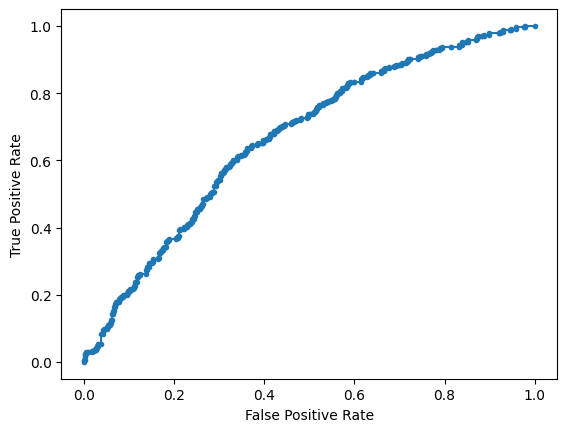

Accuracy: 62.44% Precision: 66.41% Recall: 56.42%
F1: 61.00% MCC: 0.2555
AUPRC: 65.13% AUROC: 66.64%
 accuracy [62.44239631336406]
 precision [66.40625]
 recall [56.415929203539825]
 F1 [61.00478468899523]
 MCC [0.25554609442271237]
 AUPRC [65.13294092727506]
 AUROC [66.64131637168141]

Training # 2 3
2023-04-06 19:19:50.117636
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-06 19:19:50.144348
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Valid 1:0 453:407 52.67%
FIT
2023-04-06 19:19:50.230802


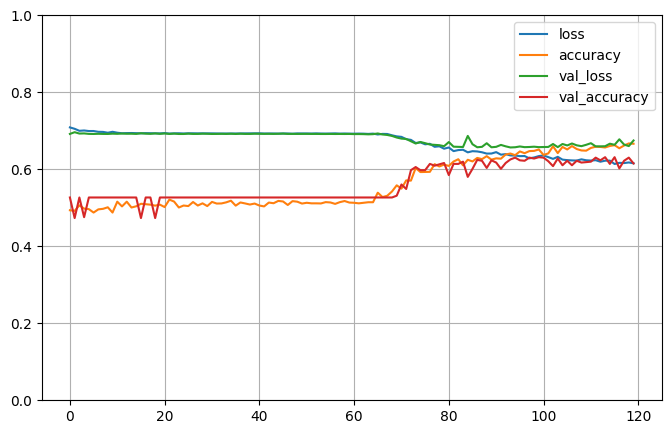


Testing # 2 3
2023-04-06 19:21:04.173079
2023-04-06 19:21:04.173130
PREDICT
2023-04-06 19:21:04.183485
Test 1:0 453:407 52.67%
Predict 1:0 390:470 45.35%
Test sizes (860, 1025) (860,)
Distrib of scores: 0.46150693 mean 0.18144827 std
Range of scores: 0.025175467 to 0.86730325
Score threshold 0.5
Confusion matrix
 [[273 134]
 [197 256]]
Normalized matrix
 [[0.31744186 0.15581395]
 [0.22906977 0.29767442]]
Correct scores pos:neg 98 169
Wrong scores pos:neg 53 88


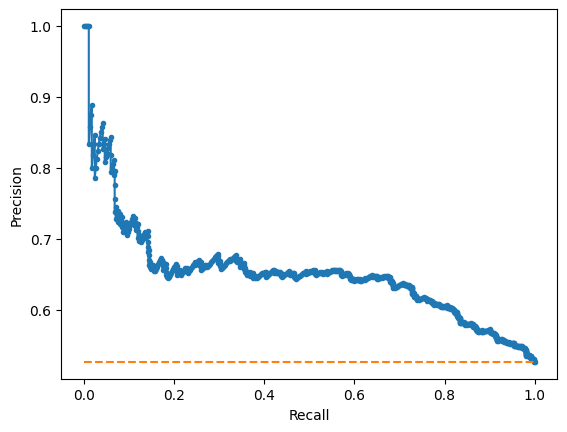

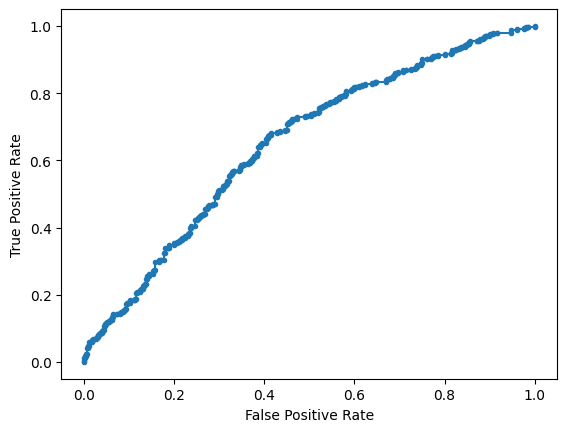

Accuracy: 61.51% Precision: 65.64% Recall: 56.51%
F1: 60.74% MCC: 0.2366
AUPRC: 65.12% AUROC: 64.99%
 accuracy [61.51162790697674]
 precision [65.64102564102564]
 recall [56.5121412803532]
 F1 [60.735468564650056]
 MCC [0.23657119822364797]
 AUPRC [65.12009556200667]
 AUROC [64.98690141074246]

Training # 2 4
2023-04-06 19:21:04.769496
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-06 19:21:04.799279
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Valid 1:0 432:447 49.15%
FIT
2023-04-06 19:21:04.883926


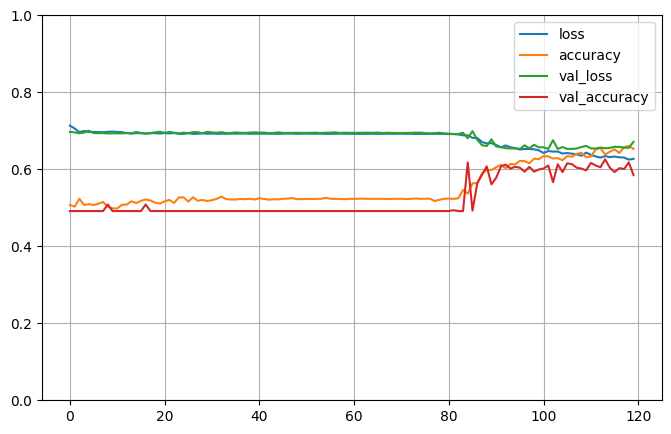


Testing # 2 4
2023-04-06 19:22:28.550296
2023-04-06 19:22:28.550342
PREDICT
2023-04-06 19:22:28.557804
Test 1:0 432:447 49.15%
Predict 1:0 619:260 70.42%
Test sizes (879, 1025) (879,)
Distrib of scores: 0.5759468 mean 0.15783207 std
Range of scores: 0.09337295 to 0.89054066
Score threshold 0.5
Confusion matrix
 [[171 276]
 [ 89 343]]
Normalized matrix
 [[0.19453925 0.31399317]
 [0.10125142 0.39021615]]
Correct scores pos:neg 200 70
Wrong scores pos:neg 113 19


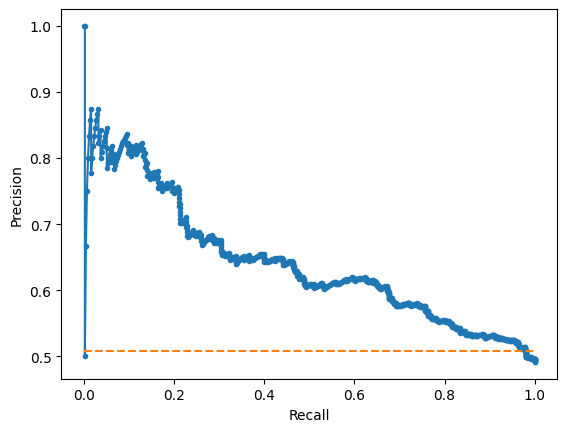

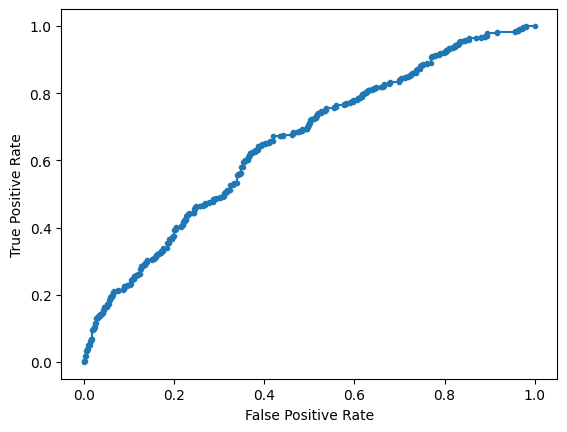

Accuracy: 58.48% Precision: 55.41% Recall: 79.40%
F1: 65.27% MCC: 0.1934
AUPRC: 64.17% AUROC: 65.42%
 accuracy [58.47554038680318]
 precision [55.41195476575121]
 recall [79.39814814814815]
 F1 [65.27117031398669]
 MCC [0.19336890054517236]
 AUPRC [64.16636298299426]
 AUROC [65.42433093048305]

Training # 2 5
2023-04-06 19:22:29.159017
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-06 19:22:29.186300
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Valid 1:0 449:426 51.31%
FIT
2023-04-06 19:22:29.324649


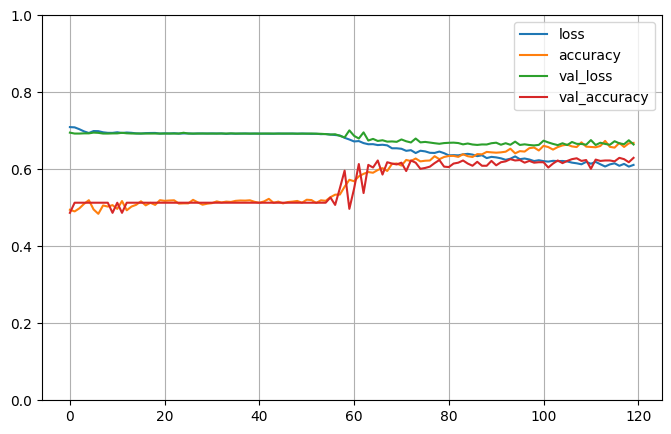


Testing # 2 5
2023-04-06 19:23:44.519617
2023-04-06 19:23:44.519665
PREDICT
2023-04-06 19:23:44.529435
Test 1:0 449:426 51.31%
Predict 1:0 511:364 58.40%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5370262 mean 0.1773242 std
Range of scores: 0.05311051 to 0.917753
Score threshold 0.5
Confusion matrix
 [[233 193]
 [131 318]]
Normalized matrix
 [[0.26628571 0.22057143]
 [0.14971429 0.36342857]]
Correct scores pos:neg 160 100
Wrong scores pos:neg 86 30


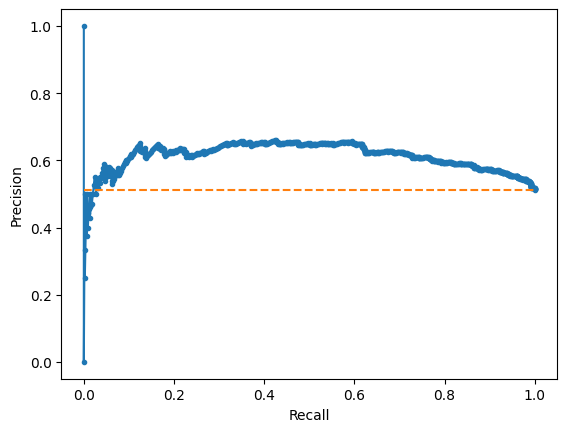

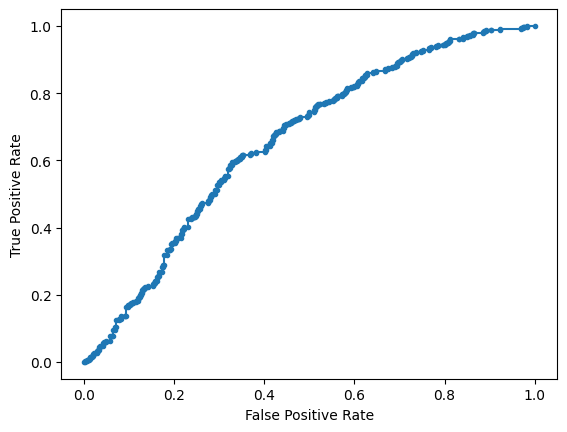

Accuracy: 62.97% Precision: 62.23% Recall: 70.82%
F1: 66.25% MCC: 0.2588
AUPRC: 61.12% AUROC: 65.78%
 accuracy [62.97142857142857]
 precision [62.230919765166334]
 recall [70.8240534521158]
 F1 [66.25]
 MCC [0.25877873960074804]
 AUPRC [61.116704456221925]
 AUROC [65.78102617187909]
2023-04-06 19:23:45.128388


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)
           
        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 60.40% std 3.69
 precision mean 61.33% std 4.76
 recall mean 69.23% std 16.26
 F1 mean 63.75% std 5.29
 MCC mean 0.2100 std 0.0817
 AUPRC mean 64.39% std 1.98
 AUROC mean 65.66% std 1.16
 accuracy [[65.28735632183908], [59.16289592760181], [62.073027090694936], [51.573033707865164], [60.73059360730594], [59.75197294250282], [62.44239631336406], [61.51162790697674], [58.47554038680318], [62.97142857142857]]
 precision [[65.1750972762646], [62.616822429906534], [59.64630225080386], [51.573033707865164], [60.44362292051756], [64.19753086419753], [66.40625], [65.64102564102564], [55.41195476575121], [62.230919765166334]]
 recall [[73.14410480349345], [45.47511312217195], [83.93665158371041], [100.0], [71.55361050328227], [55.08474576271186], [56.415929203539825], [56.5121412803532], [79.39814814814815], [70.8240534521158]]
 F1 [[68.93004115226337], [52.6867627785059], [69.73684210526316], [68.05040770941439], [65.53106212424849], [59.293044469783354], [61.00478468899523], [6